This notebook demonstrates how to collect NWM reach return periods via the BigQuery database hosted at `bigquery-public-data.national_water_model`. This requires that the Google API is authenticated on your machine. Instructions can be found [here](https://cloud.google.com/python/docs/reference/bigquery/latest).

In [1]:
#!pip install -q google-cloud-bigquery db-dtypes google-cloud-bigquery-storage

In [2]:
from google.cloud import bigquery

In [3]:
client = bigquery.Client()

In [4]:
query  = (
    'SELECT * '
    'FROM `bigquery-public-data.national_water_model.flood_return_periods` '
    'WHERE feature_id = 5984765'
)


In [5]:
query_job = client.query(query)  # API request
rows = query_job.result()  # Waits for query to finish

In [6]:
df = rows.to_dataframe()

In [7]:
df

,feature_id,return_period_2,return_period_5,return_period_10,return_period_25,return_period_50,return_period_100
0,5984765,306.4,539.74,694.23,889.43,1034.24,1177.99


# Demonstration of how this might be used.

In [8]:
import creds
from forecast import Forecasts, ForecastTypes
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
%matplotlib ipympl

In [9]:
fdata = Forecasts(creds.key)

In [10]:

nwm_reach_id = '5984765'

# Reference time is the time associated with the when
# the forecast was initiatied.
reference_time = datetime(2024,11,4)
reference_times = [reference_time.strftime('%Y-%m-%d')]

# collect all the forecast ensembles for the medium prediction.
# Medium-Range Forecast: Six-member ensemble forecasts out to 10 days (member 1) and 8.5 days (members 2-6) initialized by standard analysis and forced by a time-lagged ensemble of GFS data
fdata.collect_forecasts([nwm_reach_id],
                         ForecastTypes.MEDIUM,
                         reference_times, 
                         ensembles='all',
                         )
medium_df = fdata.df.copy()


Fetching Forecast Data:   0%|                                         | 0/1 [00:00<?, ?url/s]

In [15]:
df.return_period_2.item()

306.4

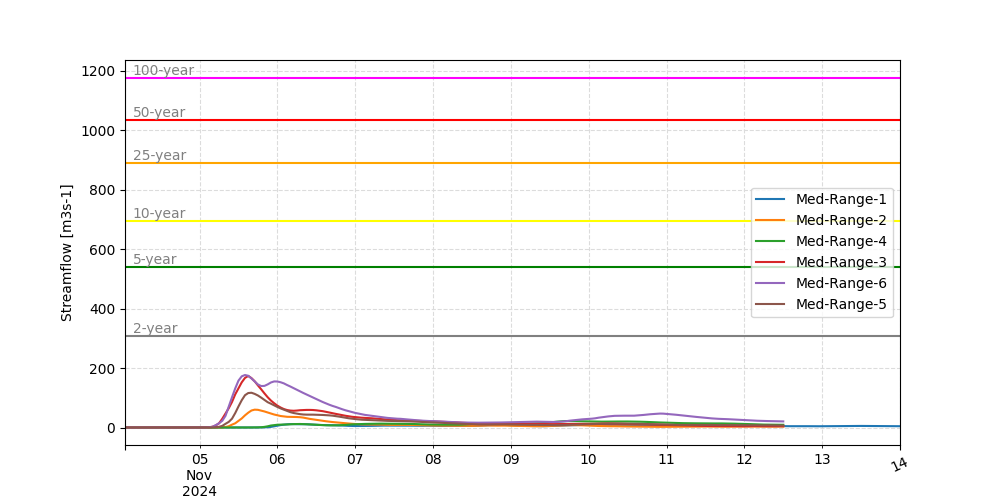

In [39]:
# Create Plots
fig, ax = plt.subplots(figsize=(10, 5))

# MEDIUM RANGE
for e in medium_df.ensemble.unique():
    label = f'Med-Range-{int(e)+1}'
    medium_df[medium_df['ensemble'] == e].plot(ax=ax, x='time', y='streamflow', label=label)

# RETURN PERIODS
ax.axhline(y=df.return_period_2.item(), color='grey', linestyle='-')
ax.text(0.01, df.return_period_2.item(), '2-year', color='grey', ha='left', va='bottom', transform=ax.get_yaxis_transform())
ax.axhline(y=df.return_period_5.item(), color='green', linestyle='-')
ax.text(0.01, df.return_period_5.item(), '5-year', color='grey', ha='left', va='bottom', transform=ax.get_yaxis_transform())
ax.axhline(y=df.return_period_10.item(), color='yellow', linestyle='-')
ax.text(0.01, df.return_period_10.item(), '10-year', color='grey', ha='left', va='bottom', transform=ax.get_yaxis_transform())
ax.axhline(y=df.return_period_25.item(), color='orange', linestyle='-')
ax.text(0.01, df.return_period_25.item(), '25-year', color='grey', ha='left', va='bottom', transform=ax.get_yaxis_transform())
ax.axhline(y=df.return_period_50.item(), color='red', linestyle='-')
ax.text(0.01, df.return_period_50.item(), '50-year', color='grey', ha='left', va='bottom', transform=ax.get_yaxis_transform())
ax.axhline(y=df.return_period_100.item(), color='magenta', linestyle='-')
ax.text(0.01, df.return_period_100.item(), '100-year', color='grey', ha='left', va='bottom', transform=ax.get_yaxis_transform())



    
# STYLING
ax.grid(which='both', axis='both', linestyle='--', color='gainsboro')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow [m3s-1]')
plt.xticks(rotation=25) 
plt.show()